In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import cvxpy
import scipy
import scs
import superscs
from wurlitzer import pipes

In [2]:
print(scs.__version__)
assert(int(scs.__version__[0]) >= 2)

2.0.2


In [3]:
probs = []

In [4]:
# Random LP
np.random.seed(hash('lp') % 2 ** 31)

# Dimensions
n = 100
m = 70

A = scipy.sparse.random(m, n, density=0.2, data_rvs = np.random.randn)
b = np.random.randn(m, 1)
c = np.random.rand(n, 1)

# Problem construction
x = cvxpy.Variable(n)
objective = cvxpy.Minimize(c.T * x)
constraints = [x >= 0, A * x <= b]
probs.append(cvxpy.Problem(objective, constraints))

In [5]:
# Optimal control
np.random.seed(hash('opt-control') % 2 ** 31)

# Problem data
T = 10
n, p = (10, 5)
A = np.random.randn(n, n)
B = np.random.randn(n, p)
x_init = np.random.randn(n, 1)
x_final = np.random.randn(n, 1)

def step(A, B, x_prev):
    x = cvxpy.Variable(n, 1)
    u = cvxpy.Variable(p, 1)
    cost = sum(cvxpy.square(u)) + sum(cvxpy.abs(x))
    constraint = (x == A * x_prev + B * u)
    return cost, constraint, x

x = cvxpy.Variable(n, 1)
constraints = [(x == x_init)]
total_cost = 0.
for t in range(T):
    cost_t, constraint_t, x = step(A, B, x)
    constraints.append(constraint_t)
    total_cost += cost_t

constraints.append(x == x_final)
probs.append(cvxpy.Problem(cvxpy.Minimize(total_cost), constraints))

In [6]:
# Lasso
np.random.seed(hash('lasso') % 2 ** 31)

# Dimensions
n = 100
m = 50

x_true = scipy.sparse.rand(n, 1, density=0.1) 
A = scipy.sparse.random(m, n, density=0.2, data_rvs = np.random.randn)
b = A * x_true + 0.1 * np.random.randn(m, 1)
mu = 1

# Problem construction
x = cvxpy.Variable(n)
objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(A*x - b) + mu * cvxpy.norm1(x))
probs.append(cvxpy.Problem(objective))

In [7]:
# Nonnegative Lasso
np.random.seed(hash('nonneg-lasso') % 2 ** 31)

# Dimensions
n = 100
m = 50

x_true = scipy.sparse.rand(n, 1, density=0.1) 
A = scipy.sparse.random(m, n, density=0.2, data_rvs = np.random.randn)
b = A * x_true + 0.1 * np.random.randn(m, 1)
mu = 1

# Problem construction
x = cvxpy.Variable(n)
objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(A*x - b) + mu * cvxpy.norm1(x))
constraints = [x >= 0]
probs.append(cvxpy.Problem(objective, constraints))

In [8]:
# SDP for closest elemwise-positive PSD matrix in some metric
np.random.seed(hash('sdp') % 2 ** 31)

# create data P
n = 50
P = np.random.randn(n, n)
P = P + P.T
Z = cvxpy.semidefinite(n)

objective = cvxpy.Maximize(cvxpy.lambda_min(P - Z))
probs.append(cvxpy.Problem(objective, [Z >= 0]))

In [9]:
# Basis pursuit
np.random.seed(hash('basis-pursuit') % 2 ** 31)

n = 300
m = 100
x = cvxpy.Variable(n)
A = np.random.rand(m, n)
x0 = scipy.sparse.rand(n, 1, 0.1)
b = A*x0

probs.append(cvxpy.Problem(cvxpy.Minimize(cvxpy.norm1(x)), [A*x == b]))

In [10]:
# Chebyshev
np.random.seed(hash('chebyshev') % 2 ** 31)

def normalized_data_matrix(m, n):
    A = np.random.randn(m, n)
    A /= np.sqrt(np.sum(A**2, 0))
    return A

m = 100
n = 200
k = 50
A = [normalized_data_matrix(m, n) for i in range(k)]
B = normalized_data_matrix(k, n)
c = np.random.rand(k)

x = cvxpy.Variable(n)
t = cvxpy.Variable(k)

f = cvxpy.max_entries(t + cvxpy.abs(B * x - c))
constraints = []
for i in range(k):
    constraints.append(cvxpy.norm(A[i]*x) <= t[i])

probs.append(cvxpy.Problem(cvxpy.Minimize(f), constraints))

In [11]:
# Least absolute deviation
np.random.seed(hash('least-abs-dev') % 2 ** 31)

m = 5000
n = 200

A = np.random.randn(m,n);
b = A.dot(np.random.randn(n))

# Add outlier noise.
k = int(0.02 * m)
idx = np.random.randint(m, size=k)
b[idx] += 10 * np.random.randn(k)

x = cvxpy.Variable(n)

probs.append(cvxpy.Problem(cvxpy.Minimize(cvxpy.norm1(A*x - b))))

In [12]:
# P-norm
np.random.seed(hash('p-norm') % 2 ** 31)

n = 20
m = int(n / 4)

G = np.random.randn(m, n)
f = np.random.randn(m, 1)

power = np.pi
x = cvxpy.Variable(n)
constraints = [G*x == f]
probs.append(cvxpy.Problem(cvxpy.Minimize(cvxpy.norm(x, power)), constraints))

In [13]:
# L1-regularized Logistic regression
np.random.seed(hash('log-reg') % 2 ** 31)

p = 1000   # features
q = 10 * p  # total samples

w_true = np.random.randn(p, 1)
X_tmp = np.random.randn(p, q)

ips = -w_true.T.dot(X_tmp)
ps = (np.exp(ips)/(1 + np.exp(ips))).T
labels = 2*(np.random.rand(q,1) < ps) - 1

X_pos = X_tmp[:,np.where(labels==1)[0]]
X_neg = X_tmp[:,np.where(labels==-1)[0]]
X = np.hstack([X_pos, -X_neg]) # include labels with data

lam = 2
w = cvxpy.Variable(p, 1)
obj = (cvxpy.sum_entries(cvxpy.log_sum_exp(cvxpy.vstack([np.zeros((1,q)), w.T*X]), axis = 0))
        + lam * cvxpy.norm(w,1))

probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [14]:
# Matrix completion
np.random.seed(hash('matrix-completion') % 2 ** 31)

m = 100
n = 50

M = np.random.randn(m * n)
n_missing = int(0.8 * m * n)
missing_idx = np.random.permutation(m * n)[:n_missing]
valid_idx = np.setdiff1d(np.arange(m * n), missing_idx)

M[missing_idx] = 0.
X = cvxpy.Variable(m * n)

lam = 0.5
diff = cvxpy.reshape(X, m, n) - np.reshape(M, (m, n))
obj = cvxpy.norm(diff, "nuc") + lam * cvxpy.sum_squares(X)
constraints = [X[valid_idx] == M[valid_idx]]

probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [15]:
# Min-norm
np.random.seed(hash('min-norm') % 2 ** 31)

m = 500
n = int(m / 2)
A = np.random.randn(m, n)
b = 10 * np.random.randn(m, 1)
G = 2 * np.random.randn(2 * n, n)

x = cvxpy.Variable(n)
obj = cvxpy.norm(A * x - b)
constraints = [cvxpy.norm(G * x) <= 1]

probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [16]:
# Lyapunov stability
np.random.seed(hash('lyapunov') % 2 ** 31)

n = 100
A = np.diag(-np.logspace(-0.5, 1, n))
U = scipy.linalg.orth(np.random.randn(n,n))
A = U.T.dot(A.dot(U))

P = cvxpy.Symmetric(n, n)
obj = cvxpy.trace(P)
constraints = [A.T*P + P*A << -np.eye(n), P >> np.eye(n)]

probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [17]:
# Portfolio
np.random.seed(hash('portfolio') % 2 ** 31)

m = 500
n = 5000
density = 0.1

mu = np.exp(0.01 * np.random.randn(n)) - 1.  # returns
D = np.random.rand(n) / 10.  # idiosyncratic risk
F = scipy.sparse.rand(n, m, density) / 10.  # factor model

lambda_risk = 1
leverage = 1

x = cvxpy.Variable(n)
obj = mu.T * x - lambda_risk * (cvxpy.sum_squares(F.T.dot(x)) +
                              cvxpy.sum_squares(cvxpy.mul_elemwise(D, x)))

constraints = [cvxpy.sum_entries(x) == leverage, x >= 0]

probs.append(cvxpy.Problem(cvxpy.Maximize(obj), constraints))

In [18]:
# Sparse covariance estimation
np.random.seed(hash('cov-estim') % 2 ** 31)

num_samples = 10
n = 20
lam = 0.1

A = scipy.sparse.rand(n, n, 0.01)
A = A.T.dot(A).todense() + 0.1 * np.eye(n)
L = np.linalg.cholesky(np.linalg.inv(A))
X = L.dot(np.random.randn(n, num_samples)) # Draw m experiments according to the covariance matrix A^-1
S = X.dot(X.T) / num_samples # Estimate of covariance matrix
mask = np.ones((n,n)) - np.eye(n)

theta = cvxpy.Variable(n, n)

obj = (lam*cvxpy.norm1(cvxpy.mul_elemwise(mask, theta)) +
       cvxpy.trace(S * theta) - cvxpy.log_det(theta))
probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [19]:
# Fused Lasso
np.random.seed(hash('fused-lasso') % 2 ** 31)

m = 1000
ni = 10
k = 1000
rho=0.05
sigma=0.05

A = np.random.randn(m, ni * k)
A /= np.sqrt(np.sum(A ** 2, 0))

x0 = np.zeros(ni * k)
for i in range(k):
    if np.random.rand() < rho:
        x0[i * ni:(i + 1) * ni] = np.random.rand()

b = A.dot(x0) + sigma * np.random.randn(m)
lam = 0.1 * sigma * np.sqrt(m * np.log(ni * k))

x = cvxpy.Variable(ni * k)
obj = cvxpy.sum_squares(A * x - b) + lam * cvxpy.norm1(x) + lam * cvxpy.tv(x)
probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [20]:
# SVM
np.random.seed(hash('svm') % 2 ** 31)

m = 150
n = 500
A = np.random.randn(m, n)
x0 = np.random.rand(n)
y = np.sign(A.dot(x0) + 0.05*np.random.randn(m))

lam = 1.0
x = cvxpy.Variable(n)
obj = ((1./m) * cvxpy.sum_entries(cvxpy.pos(1 - cvxpy.mul_elemwise(y, A * x)))
       + lam * cvxpy.norm(x, 1))

probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [21]:
# Robust PCA
np.random.seed(hash('robust-pca') % 2 ** 31)

n = 100
r = 10 # Rank
density = 0.1

L0 = np.random.randn(n, r).dot(np.random.randn(r, n)) # Low rank matrix
S0 = scipy.sparse.rand(n, n, density) # Sparse matrix w/ Normally distributed entries.
S0.data = 10 * np.random.randn(len(S0.data))

M = L0 + S0

L = cvxpy.Variable(n, n)
S = cvxpy.Variable(n, n)

lam = 0.1
obj = cvxpy.norm(L, "nuc") + lam * cvxpy.norm1(S)
constraints = [L + S == M]

probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [22]:
# Robust Gaussian covariance estimation
np.random.seed(hash('rob-cov-var') % 2 ** 31)

m = 11 # Number of observations of each random variable
n = 5 # Number of random variables
k = 3 # Needs to be less than m. 

A = np.matrix(np.random.rand(m, n))
A -= np.mean(A, axis=0)
K = np.array([(A[i].T * A[i]).flatten() for i in range(m)])

sigma_inv1 = cvxpy.Variable(n,n) # Inverse covariance matrix
t = cvxpy.Variable(m)
tdet = cvxpy.Variable(1)

obj = cvxpy.sum_largest(t+tdet, k)
z = K*cvxpy.reshape(sigma_inv1, n*n, 1)
constraints = [-cvxpy.log_det(sigma_inv1) <= tdet, t == z]
probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [23]:
# Infinite push
np.random.seed(hash('infinite-push') % 2 ** 31)

m = 100
n = 200
d = 20
np.random.seed(0)

Xp = np.random.randn(m, d)
Xn = np.random.randn(n, d)

lam = 1
theta = cvxpy.Variable(d)
Z = cvxpy.max_elemwise(1 - (Xp * theta * np.ones((1,n)) - (Xn * theta * np.ones((1,m))).T), 0)
obj = cvxpy.max_entries(cvxpy.sum_entries(Z, axis=0)) + lam * cvxpy.sum_squares(theta)
probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [24]:
# Quantile regression
np.random.seed(hash('quantile-regression') % 2 ** 31)

m = 100 # Number of data entries
n = 5 # Number of weights
k = 20 # Number of quantiles
p = 1
sigma = 0.1

x = np.random.rand(m)* 2 * np.pi * p
y = np.sin(x) + sigma * np.sin(x) * np.random.randn(m)
alphas = np.linspace(1. / (k + 1), 1 - 1. / (k + 1), k) # Do a bunch of quantiles at once

# RBF (Radial Basis Function) features
mu_rbf = np.array([np.linspace(-1, 2 * np.pi * p + 1, n)])
mu_sig = (2 * np.pi * p + 2)/n
X = np.exp(-(mu_rbf.T - x).T**2 / (2 * mu_sig**2)) # Gaussian

theta = cvxpy.Variable(n,k)

def quantile_loss(alphas, theta, X, y):
    m, n = X.shape
    k = len(alphas)
    Y = np.tile(y.flatten(), (k, 1)).T
    A = np.tile(alphas, (m, 1))
    Z = X * theta - Y
    return cvxpy.sum_entries(
        cvxpy.max_elemwise(
            cvxpy.mul_elemwise(-A, Z),
            cvxpy.mul_elemwise(1 - A, Z)))

obj = quantile_loss(alphas, theta, X, y)
constraints = [X*(theta[:,1:] - theta[:,:-1]) >= 0]
probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [25]:
# Huber regression
np.random.seed(hash('huber-regression') % 2 ** 31)

m = 5000
n = 200

x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A.dot(x0) + 0.01 * np.random.randn(m)
# Add outlier noise.
k = int(0.02 * m)
idx = np.random.randint(m, size=k)
b[idx] += 10 * np.random.randn(k)

x = cvxpy.Variable(n)
probs.append(cvxpy.Problem(cvxpy.Minimize(cvxpy.sum_entries(cvxpy.huber(A*x - b)))))

In [28]:
stgs = {
    'use_indirect' : True,
    'eps' : 1e-5,
    'verbose' : True,
    'max_iters' : 5000,
}
memory = 20
direction=150 # AA

scs_times = []
superscs_times = []
scs_iters = []
superscs_iters = []
for prob in probs:

    print('****************************************************************************')
    print('****************************************************************************')

    # For some reason I can't get CVXPY to recognize SuperSCS is installed.
    d = prob.get_problem_data(solver='SCS')
    # SuperSCS is printing to the terminal instead of the notebook
    # cell, so this useful package captures it and I print it out.
    with pipes() as (out, err):
        superscs_out = superscs.solve(d, d['dims'], memory=memory, direction=direction, do_super_scs=True, **stgs)
        superscs_out = superscs.solve(d, d['dims'], memory=memory, direction=direction, do_super_scs=False, **stgs)
    print(out.read())
    break

****************************************************************************
****************************************************************************
---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1500, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
direction = 150, memory = 20
Variables n = 100, constraints m = 170
Cones:	linear vars: 170
Setup time: 6.65e-05s
Running SuperSCS...
Memory: 340.79kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|

In [26]:
stgs = {
    'use_indirect' : True,
    'eps' : 1e-5,
    'verbose' : True,
    'max_iters' : 5000,
}
memory = 20
direction=150 # AA

scs_times = []
superscs_times = []
scs_iters = []
superscs_iters = []
for prob in probs:

    print('****************************************************************************')
    print('****************************************************************************')

    # For some reason I can't get CVXPY to recognize SuperSCS is installed.
    d = prob.get_problem_data(solver='SCS')
    scs_out = scs.solve(d, d['dims'], acceleration_lookback=memory, **stgs)
    
    # SuperSCS is printing to the terminal instead of the notebook
    # cell, so this useful package captures it and I print it out.
    with pipes() as (out, err):
        superscs_out = superscs.solve(d, d['dims'], memory=memory, direction=direction, **stgs)
    print(out.read())
    
    scs_times.append(scs_out['info']['setupTime'] + scs_out['info']['solveTime'])
    scs_iters.append(float(scs_out['info']['iter']))
    superscs_times.append(superscs_out['info']['setupTime'] + superscs_out['info']['solveTime'])
    superscs_iters.append(float(superscs_out['info']['iter']))

****************************************************************************
****************************************************************************
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1500, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 100, constraints m = 170
Cones:	linear vars: 170
Setup time: 5.22e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.09e+20  1.21e+20  1.00e+00 -6.79e+20  2.79e+20  1.95e+20  1.18e-02 
   100| 5.66e-03  

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2170, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
direction = 150, memory = 20
Variables n = 310, constraints m = 470
Cones:	primal zero / dual free vars: 120
	linear vars: 200
	soc vars: 150, soc blks: 50
Setup time: 1.77e-04s
Running SuperSCS...
Memory: 787.91kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.77e+01  2.30e-04 
   100| 1

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1502, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
direction = 150, memory = 20
Variables n = 201, constraints m = 352
Cones:	linear vars: 300
	soc vars: 52, soc blks: 1
Setup time: 1.60e-04s
Running SuperSCS...
Memory: 576.48kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.61e+01  1.73e-04 
    80| 1.00e-06  9.05e-06  6.17e-07  5.18e+00

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1020400, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 351, constraints m = 5250
Cones:	linear vars: 200
	soc vars: 5050, soc blks: 50
Setup time: 4.06e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.42e+20  4.17e+20  1.00e+00 -2.33e+20  1.23e+21  1.15e+20  8.73e-02 
   100| 1.74e-03  4.07e-03  5.03e-04  9.60e-01  9.58e-01  1.15e-16  3.00e+00 
   200| 7.39e-06  1.95e-05  5.36e-07  9.59e-01  9.59e-01  5.

  1200| 1.49e-04  7.82e-05  6.60e-06  3.75e-01  3.75e-01  1.10e-17  1.19e-01 
  1300| 1.12e-04  5.39e-05  5.41e-06  3.75e-01  3.75e-01  7.85e-18  1.29e-01 
  1400| 1.34e-04  8.39e-05  2.66e-06  3.75e-01  3.75e-01  1.76e-17  1.38e-01 
  1500| 1.15e-04  6.14e-05  1.82e-06  3.75e-01  3.75e-01  5.17e-18  1.47e-01 
  1600| 8.12e-05  4.81e-05  1.36e-07  3.75e-01  3.75e-01  5.08e-18  1.56e-01 
  1700| 1.11e-04  5.52e-05  1.08e-06  3.75e-01  3.75e-01  1.86e-17  1.64e-01 
  1800| 5.74e-05  2.75e-05  7.98e-07  3.75e-01  3.75e-01  3.76e-17  1.73e-01 
  1900| 1.28e-04  5.97e-05  2.01e-06  3.75e-01  3.75e-01  1.80e-18  1.82e-01 
  2000| 7.86e-05  4.39e-05  2.10e-06  3.75e-01  3.75e-01  1.48e-17  1.93e-01 
  2100| 7.90e-05  3.61e-05  1.09e-06  3.75e-01  3.75e-01  5.89e-18  2.02e-01 
  2200| 2.88e-04  1.28e-04  8.68e-06  3.75e-01  3.75e-01  1.63e-17  2.11e-01 
  2300| 1.89e-04  7.05e-05  7.36e-06  3.75e-01  3.75e-01  1.39e-18  2.20e-01 
  2400| 1.42e-04  8.03e-05  5.20e-06  3.75e-01  3.75e-01  5.15e-

   100| 1.92e-05  1.61e-05  3.30e-07  8.24e+02  8.24e+02  1.86e-14  1.13e+00 
   120| 1.25e-06  1.64e-06  4.05e-09  8.24e+02  8.24e+02  6.23e-15  1.30e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.30e+00s
	Lin-sys: avg # CG iterations: 3.80, avg solve time: 1.58e-03s
	Cones: avg projection time: 3.43e-03s
	Acceleration: avg step time: 4.51e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2144e-09, dist(y, K*) = 2.0390e-08, s'y/|s||y| = -1.2361e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2493e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6399e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.0502e-09
----------------------------------------------------------------------------
c'x = 824.1519, -b'y = 824.1519
---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver


---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1000100, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
direction = 150, memory = 20
Variables n = 5050, constraints m = 10100
Cones:	sd vars: 10100, sd blks: 2
Setup time: 1.73e-02s
Running SuperSCS...
Memory: 44.87MB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan       inf       inf       inf  8.81e+01  9.30e-02 
   100| 1.68e-02  2.06e-03  2.22e-04  1.04e+02  1.04e+02  

   300| 5.69e-04  3.51e-04  4.55e-04  3.32e+01  3.32e+01  3.94e-14  2.71e-01 
   400| 9.75e-05  6.23e-05  4.22e-06  3.32e+01  3.32e+01  1.04e-14  3.60e-01 
   500| 2.93e-05  1.76e-05  3.78e-06  3.32e+01  3.32e+01  1.21e-13  4.44e-01 
   580| 8.84e-06  6.01e-06  5.76e-06  3.32e+01  3.32e+01  1.57e-13  5.13e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.14e-01s
	Lin-sys: avg # CG iterations: 5.66, avg solve time: 1.69e-04s
	Cones: avg projection time: 4.38e-04s
	Acceleration: avg step time: 1.78e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3065e-09, dist(y, K*) = 1.4547e-08, s'y/|s||y| = 8.9631e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.8382e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.0125e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.7611e-06
----------------------------------------------------------------------------
c'x = 33.1556, -

   200| 3.96e-02  7.54e-02  6.71e-02  1.82e+00  1.53e+00  6.77e-16  4.01e-01 
   300| 4.05e-02  7.08e-02  6.56e-02  1.46e+00  1.73e+00  2.00e-15  6.16e-01 
   400| 1.58e-02  2.71e-02  2.45e-03  1.12e+00  1.11e+00  1.91e-15  8.26e-01 
   500| 7.59e-03  1.27e-02  8.52e-03  1.11e+00  1.14e+00  3.77e-16  1.03e+00 
   600| 1.07e-02  1.53e-02  3.27e-02  9.97e-01  9.02e-01  1.96e-15  1.25e+00 
   700| 7.93e-03  8.56e-03  1.61e-03  1.05e+00  1.04e+00  1.50e-16  1.46e+00 
   800| 8.75e-03  1.44e-02  1.82e-02  1.02e+00  9.64e-01  3.32e-17  1.68e+00 
   900| 1.07e-02  1.82e-02  2.08e-02  1.01e+00  9.48e-01  2.09e-15  1.89e+00 
  1000| 1.27e-02  2.07e-02  4.05e-03  1.05e+00  1.04e+00  5.87e-17  2.11e+00 
  1100| 4.41e-03  7.36e-03  7.53e-03  1.02e+00  9.93e-01  8.45e-16  2.33e+00 
  1200| 6.23e-03  9.00e-03  1.49e-02  1.00e+00  9.57e-01  1.48e-16  2.55e+00 
  1300| 4.76e-03  8.29e-03  2.13e-03  1.02e+00  1.02e+00  2.11e-15  2.77e+00 
  1400| 1.18e-02  1.34e-02  1.01e-02  1.02e+00  1.05e+00  7.50e-

     0| 3.28e+21  3.59e+21  1.00e+00 -1.10e+25  4.78e+24  1.04e+24  7.55e-02 
   100| 7.81e-04  9.05e-04  1.63e-04  1.80e+03  1.80e+03  5.91e-13  3.76e+00 
   200| 4.36e-05  3.92e-05  2.32e-07  1.80e+03  1.80e+03  1.66e-13  7.48e+00 
   300| 1.63e-05  1.45e-05  8.44e-07  1.80e+03  1.80e+03  1.10e-13  1.12e+01 
   320| 2.38e-06  2.43e-06  1.85e-07  1.80e+03  1.80e+03  2.66e-13  1.19e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.19e+01s
	Lin-sys: avg # CG iterations: 5.76, avg solve time: 7.77e-03s
	Cones: avg projection time: 1.27e-02s
	Acceleration: avg step time: 1.28e-02s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.1394e-08, dist(y, K*) = 1.3399e-04, s'y/|s||y| = 2.2033e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.3830e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.4288e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.8545e-07
---------------

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 460222, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 20022, constraints m = 40222
Cones:	linear vars: 40200
	soc vars: 22, soc blks: 1
Setup time: 2.20e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.15e+20  1.57e+21  1.00e+00 -3.46e+22  1.28e+23  1.75e+22  5.74e-02 
   100| 4.66e-03  1.41e-02  6.07e-04  9.99e+01  9.98e+01  5.98e-15  1.89e+00 
   200| 2.49e-06  1.99e-05  1.40e-07  1.00e+02  1.00e+02  3

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 43000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
direction = 150, memory = 20
Variables n = 2100, constraints m = 5900
Cones:	linear vars: 5900
Setup time: 7.58e-04s
Running SuperSCS...
Memory: 10.97MB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0| 2.28e+00  1.97e+00  9.99e-01 -1.32e+03  7.71e+01  0.00e+00  4.45e+01  1.78e-02 
   100| 3.19e-03  1.39e-02  2.20e-03  3.75e+01  3.76e+01  0.00e+00  2.

(array([1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 2., 0., 2.,
        2., 2., 1., 2., 0., 0., 1., 0., 1., 0., 0., 0., 1.]),
 array([-8.63989225e-01, -7.55899128e-01, -6.47809030e-01, -5.39718932e-01,
        -4.31628834e-01, -3.23538736e-01, -2.15448638e-01, -1.07358540e-01,
         7.31557965e-04,  1.08821656e-01,  2.16911754e-01,  3.25001852e-01,
         4.33091950e-01,  5.41182048e-01,  6.49272146e-01,  7.57362243e-01,
         8.65452341e-01,  9.73542439e-01,  1.08163254e+00,  1.18972264e+00,
         1.29781273e+00,  1.40590283e+00,  1.51399293e+00,  1.62208303e+00,
         1.73017312e+00,  1.83826322e+00,  1.94635332e+00,  2.05444342e+00,
         2.16253352e+00,  2.27062361e+00,  2.37871371e+00]),
 <a list of 30 Patch objects>)

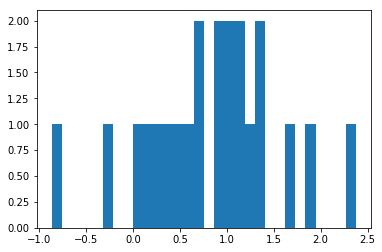

In [27]:
plt.hist(np.log(np.array(superscs_times)/np.array(scs_times)), bins=30)

(array([1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 2., 0., 0., 1., 2., 3., 0.,
        2., 1., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.]),
 array([-1.04698792, -0.95148577, -0.85598361, -0.76048145, -0.6649793 ,
        -0.56947714, -0.47397498, -0.37847283, -0.28297067, -0.18746851,
        -0.09196636,  0.0035358 ,  0.09903796,  0.19454011,  0.29004227,
         0.38554443,  0.48104658,  0.57654874,  0.6720509 ,  0.76755305,
         0.86305521,  0.95855737,  1.05405952,  1.14956168,  1.24506384,
         1.34056599,  1.43606815,  1.53157031,  1.62707246,  1.72257462,
         1.81807678]),
 <a list of 30 Patch objects>)

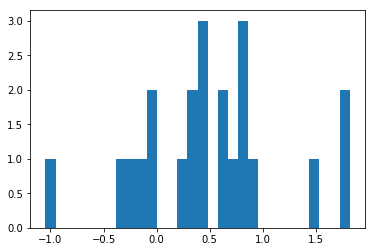

In [28]:
plt.hist(np.log(np.array(superscs_iters)/np.array(scs_iters)), bins=30)

In [29]:
stgs['use_indirect'] = False,

scs_times = []
superscs_times = []
scs_iters = []
superscs_iters = []

for prob in probs:

    print('****************************************************************************')
    print('****************************************************************************')

    # For some reason I can't get CVXPY to recognize SuperSCS is installed.
    d = prob.get_problem_data(solver='SCS')
    scs_out = scs.solve(d, d['dims'], acceleration_lookback=memory, **stgs)
    
    # SuperSCS is printing to the terminal instead of the notebook
    # cell, so this useful package captures it and I print it out.
    with pipes() as (out, err):
        superscs_out = superscs.solve(d, d['dims'], memory=memory, direction=direction, **stgs)
    print(out.read())
    
    scs_times.append(scs_out['info']['setupTime'] + scs_out['info']['solveTime'])
    scs_iters.append(float(scs_out['info']['iter']))
    superscs_times.append(superscs_out['info']['setupTime'] + superscs_out['info']['solveTime'])
    superscs_iters.append(float(superscs_out['info']['iter']))

****************************************************************************
****************************************************************************
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1500, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 100, constraints m = 170
Cones:	linear vars: 170
Setup time: 3.88e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.09e+20  1.21e+20  1.00e+00 -6.79e+20  2.79e+20  1.95e+20  7.47e-03 
   100| 5.66e-03  

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2170, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
direction = 150, memory = 20
Variables n = 310, constraints m = 470
Cones:	primal zero / dual free vars: 120
	linear vars: 200
	soc vars: 150, soc blks: 50
Setup time: 1.50e-04s
Running SuperSCS...
Memory: 787.91kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.77e+01  2.30e-04 
   100| 1

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1502, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
direction = 150, memory = 20
Variables n = 201, constraints m = 352
Cones:	linear vars: 300
	soc vars: 52, soc blks: 1
Setup time: 1.22e-04s
Running SuperSCS...
Memory: 576.48kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.61e+01  1.49e-04 
    80| 1.00e-06  9.05e-06  6.17e-07  5.18e+00

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1020400, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 351, constraints m = 5250
Cones:	linear vars: 200
	soc vars: 5050, soc blks: 50
Setup time: 4.11e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.42e+20  4.17e+20  1.00e+00 -2.33e+20  1.23e+21  1.15e+20  8.48e-02 
   100| 1.74e-03  4.07e-03  5.03e-04  9.60e-01  9.58e-01  1.15e-16  2.91e+00 
   200| 7.39e-06  1.95e-05  5.36e-07  9.59e-01  9.59e-01  5.

  2300| 1.89e-04  7.05e-05  7.36e-06  3.75e-01  3.75e-01  1.39e-18  1.99e-01 
  2400| 1.42e-04  8.03e-05  5.20e-06  3.75e-01  3.75e-01  5.15e-17  2.08e-01 
  2500| 7.03e-05  3.49e-05  3.32e-06  3.75e-01  3.75e-01  1.00e-17  2.18e-01 
  2600| 9.78e-05  4.05e-05  2.70e-06  3.75e-01  3.75e-01  1.27e-17  2.26e-01 
  2700| 2.57e-05  1.33e-05  9.85e-07  3.75e-01  3.75e-01  4.35e-18  2.35e-01 
  2800| 1.27e-05  6.43e-06  1.88e-07  3.75e-01  3.75e-01  9.41e-18  2.44e-01 
  2900| 2.34e-05  1.02e-05  3.46e-08  3.75e-01  3.75e-01  5.03e-18  2.52e-01 
  3000| 1.02e-05  4.31e-06  1.42e-07  3.75e-01  3.75e-01  7.67e-18  2.60e-01 
  3020| 8.86e-06  4.25e-06  4.06e-08  3.75e-01  3.75e-01  1.91e-17  2.62e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.62e-01s
	Lin-sys: avg # CG iterations: 6.47, avg solve time: 3.60e-05s
	Cones: avg projection time: 1.94e-06s
	Acceleration: avg step time: 2.81e-05s
----------------------------------

   100| 1.92e-05  1.61e-05  3.30e-07  8.24e+02  8.24e+02  1.86e-14  1.31e+00 
   120| 1.25e-06  1.64e-06  4.05e-09  8.24e+02  8.24e+02  6.23e-15  1.52e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.52e+00s
	Lin-sys: avg # CG iterations: 3.80, avg solve time: 2.03e-03s
	Cones: avg projection time: 4.29e-03s
	Acceleration: avg step time: 4.75e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2144e-09, dist(y, K*) = 2.0390e-08, s'y/|s||y| = -1.2361e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2493e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6399e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.0502e-09
----------------------------------------------------------------------------
c'x = 824.1519, -b'y = 824.1519
---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver


---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1000100, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
direction = 150, memory = 20
Variables n = 5050, constraints m = 10100
Cones:	sd vars: 10100, sd blks: 2
Setup time: 1.75e-02s
Running SuperSCS...
Memory: 44.87MB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan       inf       inf       inf  8.81e+01  8.98e-02 
   100| 1.68e-02  2.06e-03  2.22e-04  1.04e+02  1.04e+02  

   300| 5.69e-04  3.51e-04  4.55e-04  3.32e+01  3.32e+01  3.94e-14  2.71e-01 
   400| 9.75e-05  6.23e-05  4.22e-06  3.32e+01  3.32e+01  1.04e-14  3.55e-01 
   500| 2.93e-05  1.76e-05  3.78e-06  3.32e+01  3.32e+01  1.21e-13  4.40e-01 
   580| 8.84e-06  6.01e-06  5.76e-06  3.32e+01  3.32e+01  1.57e-13  5.11e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.11e-01s
	Lin-sys: avg # CG iterations: 5.66, avg solve time: 1.69e-04s
	Cones: avg projection time: 4.35e-04s
	Acceleration: avg step time: 1.71e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3065e-09, dist(y, K*) = 1.4547e-08, s'y/|s||y| = 8.9631e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.8382e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.0125e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.7611e-06
----------------------------------------------------------------------------
c'x = 33.1556, -

   100| 8.96e-02  1.98e-01  8.01e-02  3.02e+00  3.63e+00  2.49e-15  1.90e-01 
   200| 3.96e-02  7.54e-02  6.71e-02  1.82e+00  1.53e+00  6.77e-16  3.98e-01 
   300| 4.05e-02  7.08e-02  6.56e-02  1.46e+00  1.73e+00  2.00e-15  6.16e-01 
   400| 1.58e-02  2.71e-02  2.45e-03  1.12e+00  1.11e+00  1.91e-15  8.24e-01 
   500| 7.59e-03  1.27e-02  8.52e-03  1.11e+00  1.14e+00  3.77e-16  1.04e+00 
   600| 1.07e-02  1.53e-02  3.27e-02  9.97e-01  9.02e-01  1.96e-15  1.26e+00 
   700| 7.93e-03  8.56e-03  1.61e-03  1.05e+00  1.04e+00  1.50e-16  1.47e+00 
   800| 8.75e-03  1.44e-02  1.82e-02  1.02e+00  9.64e-01  3.32e-17  1.69e+00 
   900| 1.07e-02  1.82e-02  2.08e-02  1.01e+00  9.48e-01  2.09e-15  1.90e+00 
  1000| 1.27e-02  2.07e-02  4.05e-03  1.05e+00  1.04e+00  5.87e-17  2.12e+00 
  1100| 4.41e-03  7.36e-03  7.53e-03  1.02e+00  9.93e-01  8.45e-16  2.33e+00 
  1200| 6.23e-03  9.00e-03  1.49e-02  1.00e+00  9.57e-01  1.48e-16  2.55e+00 
  1300| 4.76e-03  8.29e-03  2.13e-03  1.02e+00  1.02e+00  2.11e-

   100| 7.81e-04  9.05e-04  1.63e-04  1.80e+03  1.80e+03  5.91e-13  3.74e+00 
   200| 4.36e-05  3.92e-05  2.32e-07  1.80e+03  1.80e+03  1.66e-13  7.41e+00 
   300| 1.63e-05  1.45e-05  8.44e-07  1.80e+03  1.80e+03  1.10e-13  1.10e+01 
   320| 2.38e-06  2.43e-06  1.85e-07  1.80e+03  1.80e+03  2.66e-13  1.17e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.18e+01s
	Lin-sys: avg # CG iterations: 5.76, avg solve time: 7.69e-03s
	Cones: avg projection time: 1.27e-02s
	Acceleration: avg step time: 1.26e-02s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.1394e-08, dist(y, K*) = 1.3399e-04, s'y/|s||y| = 2.2033e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.3830e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.4288e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.8545e-07
----------------------------------------------------------------------------
c'x = 1801.4300,

     0| 9.15e+20  1.57e+21  1.00e+00 -3.46e+22  1.28e+23  1.75e+22  4.80e-02 
   100| 4.66e-03  1.41e-02  6.07e-04  9.99e+01  9.98e+01  5.98e-15  1.88e+00 
   200| 2.49e-06  1.99e-05  1.40e-07  1.00e+02  1.00e+02  3.16e-15  3.36e+00 
   240| 6.95e-07  9.48e-06  5.03e-08  1.00e+02  1.00e+02  1.62e-14  3.80e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.80e+00s
	Lin-sys: avg # CG iterations: 5.16, avg solve time: 9.50e-03s
	Cones: avg projection time: 3.59e-05s
	Acceleration: avg step time: 4.84e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.8684e-15, dist(y, K*) = 0.0000e+00, s'y/|s||y| = 2.1730e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.9502e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.4841e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.0263e-08
----------------------------------------------------------------------------
c'x = 100.0000, 

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1045000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 20200, constraints m = 30000
Cones:	primal zero / dual free vars: 5000
	linear vars: 10000
	soc vars: 15000, soc blks: 5000
Setup time: 3.81e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.46e+21  2.29e+21  1.00e+00 -1.88e+25  7.73e+23  4.01e+24  6.80e-02 
   100| 3.89e-03  5.86e-03  1.55e-03  1.49e+03  1.49e+03  1.63e-13  2.13e+00 
   200| 7.48e-04

(array([2., 0., 1., 0., 1., 0., 2., 1., 0., 1., 0., 2., 2., 1., 0., 1., 0.,
        1., 3., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.]),
 array([-0.25324822, -0.1655426 , -0.07783698,  0.00986864,  0.09757426,
         0.18527989,  0.27298551,  0.36069113,  0.44839675,  0.53610238,
         0.623808  ,  0.71151362,  0.79921924,  0.88692487,  0.97463049,
         1.06233611,  1.15004173,  1.23774736,  1.32545298,  1.4131586 ,
         1.50086422,  1.58856984,  1.67627547,  1.76398109,  1.85168671,
         1.93939233,  2.02709796,  2.11480358,  2.2025092 ,  2.29021482,
         2.37792045]),
 <a list of 30 Patch objects>)

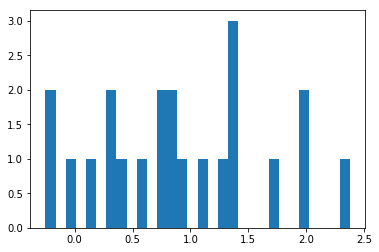

In [30]:
plt.hist(np.log(np.array(superscs_times)/np.array(scs_times)), bins=30)

(array([1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 2., 0., 0., 1., 2., 3., 0.,
        2., 1., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.]),
 array([-1.04698792, -0.95148577, -0.85598361, -0.76048145, -0.6649793 ,
        -0.56947714, -0.47397498, -0.37847283, -0.28297067, -0.18746851,
        -0.09196636,  0.0035358 ,  0.09903796,  0.19454011,  0.29004227,
         0.38554443,  0.48104658,  0.57654874,  0.6720509 ,  0.76755305,
         0.86305521,  0.95855737,  1.05405952,  1.14956168,  1.24506384,
         1.34056599,  1.43606815,  1.53157031,  1.62707246,  1.72257462,
         1.81807678]),
 <a list of 30 Patch objects>)

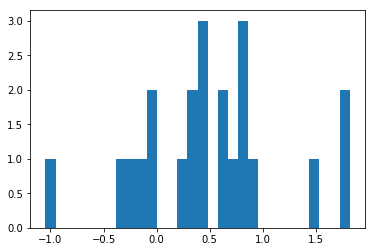

In [31]:
plt.hist(np.log(np.array(superscs_iters)/np.array(scs_iters)), bins=30)